In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten ,Reshape, Input ,Conv2D
import matplotlib.pyplot as plt
import numpy as np


In [2]:
#from keras.api._v2.keras import experimental
import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
(x_train,y_train),(x_test,y_test)=keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
x_dataset=tf.data.Dataset.from_tensor_slices(x_train)
y_dataset=tf.data.Dataset.from_tensor_slices(y_train)
x_dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None)>

In [5]:
def process_x(x):
  img=tf.cast(x,tf.float32)/255
  return img

def process_y(y):
  y=tf.one_hot(y,10)
  return y

x_dataset=x_dataset.map(process_x)
y_dataset=y_dataset.map(process_y)

dataset=tf.data.Dataset.zip((x_dataset,y_dataset))
dataset=dataset.shuffle(1000)
dataset=dataset.batch(64)
AUTOTUNE=tf.data.AUTOTUNE
dataset=dataset.cache().prefetch(buffer_size=AUTOTUNE)

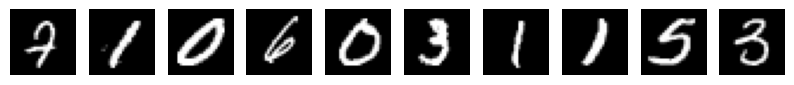

In [6]:
def imshow():
  n=10
  plt.figure(figsize=(10,6))
  for images,labels in dataset.take(1):
    for i in range(n):
      img=images[i]
      ax=plt.subplot(3,n,i+1+n)
      plt.imshow(img,cmap='gist_gray')
      plt.axis('off')
      ax.get_yaxis().set_visible(False)
  plt.show()
imshow()


In [12]:
inputs=Input(shape=(28,28))
x=Reshape((28,28,1))(inputs)
x=Conv2D(32,3,activation='relu',padding='same')(x)
x=Conv2D(32,3,activation='relu',strides=2,padding='same')(x)
x=Conv2D(64,3,activation='relu',padding='same')(x)
x=Conv2D(64,3,activation='relu',strides=2,padding='same')(x)
x=Conv2D(128,3,activation='relu',padding='same')(x)
x=Conv2D(128,3,activation='relu',strides=2,padding='same')(x)
x=Flatten()(x)
x=Dense(128,activation='relu')(x)
x=Dense(10,activation='sigmoid')(x)
outputs=x
cnn=keras.Model(inputs,outputs)

In [13]:
cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 128)         7385

In [14]:
class Model(tf.keras.Model):
  def __init__(self,nn):
    super(Model,self).__init__()
    self.nn=nn

  def get_loss(self,y,preds):
    loss=tf.keras.losses.CategoricalCrossentropy()(y,preds)
    return loss
  @tf.function
  def training_step(self,x,y):
    with tf.GradientTape() as tape:
      preds=self.nn(x)
      loss=self.get_loss(y,preds)
    gradients=tape.gradient(loss,self.nn.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients,self.nn.trainable_variables))
    return tf.reduce_mean(loss)

In [15]:
model=Model(cnn)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

In [16]:
for x,y in dataset.take(1):
  print(model.training_step(x,y))

tf.Tensor(2.301365, shape=(), dtype=float32)


100


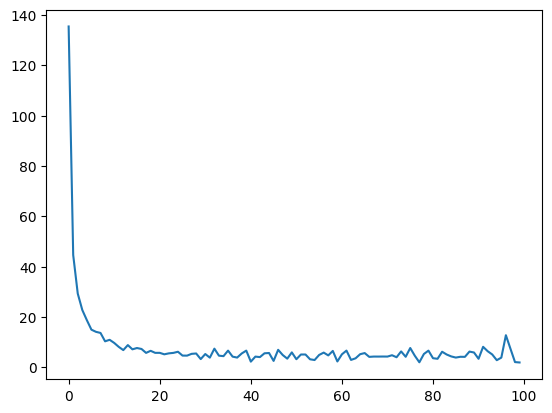

In [17]:
from IPython.display import clear_output
hist=np.array(np.empty([0]))
epochs = 100
for epoch in range(1,epochs + 1):
  loss = 0
  for step ,(x,y) in enumerate(dataset):
    loss+=model.training_step(x,y)
  clear_output(wait=True)
  print(epoch)
  hist=np.append(hist,loss)
  plt.plot(np.arange(0,len(hist)),hist)
  plt.show()


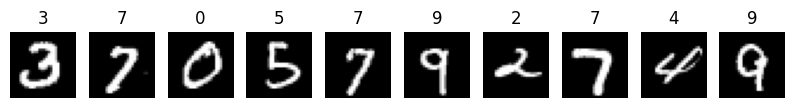

In [18]:
def imshow_and_pred():
  n=10
  plt.figure(figsize=(10,5))
  for images, labels in dataset.take(1):
    for i in range(n):
      img=images[i]
      img_tensor=tf.expand_dims(img,axis=0)
      pred=model.nn(img_tensor)
      pred=tf.squeeze(pred,axis=0)
      pred=pred.numpy()

      ax=plt.subplot(3,n,i+1+n)
      plt.imshow(img,cmap='gist_gray')

      ma=pred.max()
      res=np.where(pred==ma)

      plt.title(res[0][0])
      plt.axis('off')
      ax.get_yaxis().set_visible(False)
  plt.show()

imshow_and_pred()

In [19]:
import cv2
my_img=cv2.imread("images.png")
my_img=my_img
img_tensor=tf.expand_dims(my_img,axis=0)
print(img_tensor[:,:2])
img_tensor=tf.cast(img_tensor,tf.float32)/255
img_tensor=tf.image.resize(img_tensor,(28,28),method='area')
print(img_tensor[:,1])
img_numpy=img_tensor.numpy()
img_numpy=img_numpy[:,:,:,0]

pred=model.nn(img_numpy)
pred=tf.squeeze(pred,axis=0)
print(pred)
pred=pred.numpy()

ma=pred.max()
print(ma)
res=np.where(pred==ma)
print(res[0][0])

tf.Tensor(
[[[[254 254 251]
   [255 253 251]
   [255 253 251]
   ...
   [239 145  97]
   [255 251 240]
   [255 252 255]]

  [[255 255 253]
   [255 255 253]
   [255 255 253]
   ...
   [241 145 100]
   [255 251 242]
   [255 251 255]]]], shape=(1, 2, 201, 3), dtype=uint8)
tf.Tensor(
[[[0.9999999  0.9999999  0.9999999 ]
  [0.9999999  0.9999999  0.9999999 ]
  [0.9999998  0.9999998  0.9999998 ]
  [1.0000002  1.0000002  1.0000002 ]
  [1.0000002  1.0000002  1.0000002 ]
  [0.9999998  0.9999998  0.9999998 ]
  [1.0000004  1.0000004  1.0000004 ]
  [0.9999998  0.9999998  0.9999998 ]
  [0.9999998  0.9999998  0.9999998 ]
  [1.0000004  1.0000004  1.0000004 ]
  [1.0000004  1.0000004  1.0000004 ]
  [0.9999993  0.9999993  0.9999993 ]
  [1.0000004  1.0000004  1.0000004 ]
  [1.0000004  1.0000004  1.0000004 ]
  [0.9999993  0.9999993  0.9999993 ]
  [0.9881641  0.9345811  0.93401396]
  [0.49290845 0.4872933  0.48838204]
  [0.31703657 0.25457644 0.25982213]
  [0.37640983 0.3182495  0.32569593]
  [0.1207571  0.

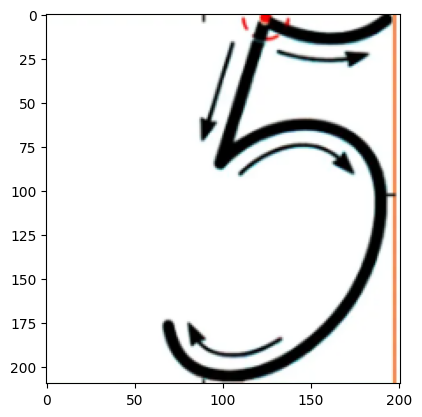

In [ ]:
plt.imshow(my_img,cmap='gist_gray')